# Complex-Valued Deep Learning

In this notebook we are going to make some tests on complex-valued neural networks. <br>
We will implements some models, test their convergence properties over some datasets, checking which are the effective situations in which they outperform equivalent real-valued models. Furthermore, we will make some tests involving the stability of the convergence.

## PhaseMNIST

Another big obstacle in the development of a complete and working complex-valued deep learning framework was the absolute absence of available datasets. Surfing the internet, the number of inherently complex datasets available for machine learning purposes, is very very small. Reasonable, from a certain point of view, since real world measures are only real-valued. <br>
A possibility, also coherent with the final application areas of complex-valued models, could have been looking for datasets of signals: electric, seismic or even biological signals can easily be studied also in the momentum space, replacing the time series with a complex spectrogram or at least the complex coefficients coming from the Fourier transforms. <br>
However, in this notebook I wanted to make just a superficial analysis, leaving real-world challenging tasks to future works. And, for this reason, I needed a sufficiently small and "simple" dataset to train small/medium-sized models in a reasonable amount of time, several times each. I wanted something more similar to a qualitative, rather than quantitative, analysis, giving more attention to the stability of the loss function during the training phase or to configurations that are more likely to overfit, rather than to the final accuracy reached.

In our help it comes a very recent work by _Ziller et. al._, `Complex-Valued Deep Learning with Differential Privacy`: regarding this article, we are not really interested to this branch of deep learning but more on the dataset they have used. For the area of supervised deep learning, the _MNIST_ is probably one of the most used benchmark datasets for real-valued models. In $C$ there is not such availability, and so the authors come up with this proposal: a complex-valued adaptation of MNIST, called __PhaseMNIST__. In brief, for each example in the original set with label $L_{\Re}\in\{0,...,9\}$, we select another image with label $L_{\Im}$ such that $L_{\Re} + L_{\Im} = 9$, resulting in an input image rearrangement $(0,9),(1,8),...,(9,0)$. You build then new complex data stacking this pair of images, and keeping as label the one of the real part (imagine the lack of dataset, since those people had to come up with such an idea). <br>
Obviously, we could have directly used the original MNIST even with a complex-valued model, but in that case the imaginary part of our weights would have not learnt anything, vanishing the benefits that we instead would like to proove.

### Dependencies

In [8]:
import haiku as hk
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
from importlib import reload
import torch 
import torchvision
from torchvision import transforms
import torchaudio
from pathlib import Path
import pickle
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
sns.set_theme()
%matplotlib inline

In [9]:
import jax
import jax.numpy as jnp
import haiku as hk
from complex_nn.layers import Cmplx_Linear, Cmplx_Normalization, Dropout, CmplxBatchNorm
from complex_nn.activations import cardioid
from complex_nn.haiku_ml_utils import haiku_check_model_parameters
from complex_nn.optimizers import cmplx_adam
from complex_nn.Classifier_wrapper import Haiku_Classifier
from complex_nn.utils import small_training_summary, get_circularity_coeff

### Data Generation

Thanks to Pytorch, we can easily load/download MNIST, and so we just need to build its complex-valued counterpart, following the explanation above, and save it somewhere.

In [10]:
def generate_PhaseMNIST(mnist_path, download=False):
    
    mnist_train_ds = torchvision.datasets.MNIST(root=mnist_path, train=True, download=download)
    mnist_test_ds = torchvision.datasets.MNIST(root=mnist_path, train=False, download=download)
    
    phasemnist_data = []
    phasemnist_labels = []
    
    for dataset in [mnist_train_ds, mnist_test_ds]:
        
        for label in tqdm(range(10)):
            
            # Get targets pairs (such that real_target + imag_target = 9)
            real_targets_idxs = (dataset.targets == label)
            imag_targets_idxs = (dataset.targets == (9-label))
    
            real_samples = dataset.data[real_targets_idxs]
            imag_samples = dataset.data[imag_targets_idxs]
            
            # Get len(real) random samples from the imaginary dataset
            imag_mask = np.random.randint(low=0, high=len(imag_samples), size=len(real_samples))
    
            # Construct the PhaseMNIST samples
            phasemnist_samples = np.asarray(real_samples) / 255. + 1.j*np.array(imag_samples[imag_mask]) / 255.
            
            phasemnist_data.append(phasemnist_samples)
            phasemnist_labels.append(np.full(len(phasemnist_samples), label))

    phasemnist_data_array = np.concatenate(phasemnist_data)
    phasemnist_labels_array = np.concatenate(phasemnist_labels)
    
    # Shuffle the two arrays
    perm = np.random.permutation(len(phasemnist_labels_array))
    phasemnist_data_array = phasemnist_data_array[perm]
    phasemnist_labels_array = phasemnist_labels_array[perm]
        
    with open(mnist_path + 'PhaseMNIST/data.npy', 'wb') as f:
        np.save(f, phasemnist_data_array)
    
    with open(mnist_path + 'PhaseMNIST/labels.npy', 'wb') as f:
        np.save(f, phasemnist_labels_array)
            
    return phasemnist_data_array, phasemnist_labels_array

In [11]:
#data, labels = generate_PhaseMNIST('data/')

Once built the dataset, it useful to load it using a pair of a Dataset and a Dataloader, in the traditional Pytorch approach.

In [12]:
class PhaseMNIST(Dataset):
    
    def __init__(self, path, transform=None):
        
        with open(path + 'data.npy', 'rb') as f:
            self.data = np.load(f)
            
        with open(path + 'labels.npy', 'rb') as f:
            self.labels = np.load(f)
        
        self.length = len(self.labels)
        self.transform = transform
        
    def __len__(self):
        return self.length
    
    def __getitem__(self, index):
        
        sample = (self.data[index], self.labels[index])
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample

In [13]:
class ToTensor_onehot(object):
    """Convert sample to Tensors and one-hot encode the labels."""
    def __init__(self, n_classes=2):
        self.n_classes = n_classes

    def __call__(self, sample):
        x, y = sample
        # One-hot encoding
        y = np.eye(self.n_classes)[y]
        return ( torch.from_numpy(x), torch.tensor([y]) )
    
class Squeeze(object):
    """Remove the extra dimensions of the tensors."""
    def __init__(self, squeeze_x=True, squeeze_y=True):
        self.squeeze_x = squeeze_x
        self.squeeze_y = squeeze_y
    
    def __call__(self, sample):
        x, y = sample
        if self.squeeze_x:
            x = torch.squeeze(x)
        if self.squeeze_y:
            y = torch.squeeze(y)
        return ( x, y )

In [14]:
def build_dataloaders(data_dir, composed_transform, drop_length=0, test_frac=0.25, batch_size=32):
    
    full_dataset = PhaseMNIST(path=data_dir, transform=composed_transform)
    
    train_len = int((1.-test_frac) * (len(full_dataset)-drop_length))
    test_len = len(full_dataset) - train_len - drop_length
    train_ds, test_ds, _ = torch.utils.data.random_split(full_dataset, [train_len, test_len, drop_length])
    
    #print( get_circularity_coeff(train_ds) )
    #print( get_circularity_coeff(test_ds) )
        
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=True)
    
    return train_dataloader, test_dataloader

In [15]:
mnist_path = 'data/PhaseMNIST/'
batch_size = 64
drop_length = 60000
data_transform = transforms.Compose([ToTensor_onehot(n_classes=10), Squeeze(squeeze_x=False)])

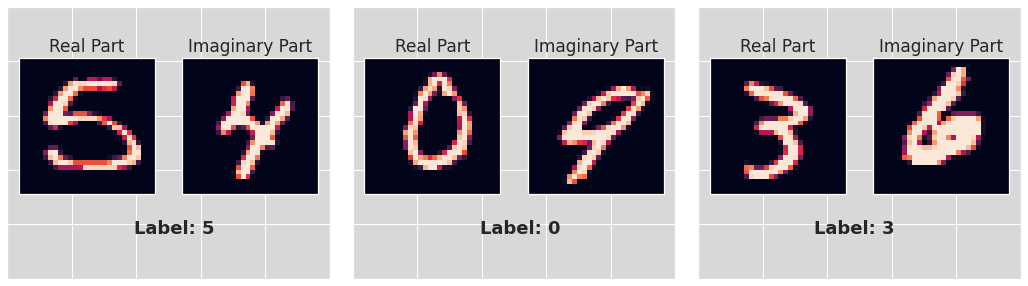

In [17]:
phasemnist_ds = PhaseMNIST(path=mnist_path, transform=None)

# Let's see what's inside a random sample.
fig = plt.figure(figsize=(16,5))

labels = []
for i in range(3):

    rnd_sample = phasemnist_ds[np.random.randint(len(phasemnist_ds))]
    labels.append( rnd_sample[1] )
    
    # outer
    outer_gs = gridspec.GridSpec(1, 1)
    outer_gs.update(left=(i%3)*0.3+0.01, right=(1+i%3)*0.3-0.01)

    outer_ax = fig.add_subplot(outer_gs[0])
    outer_ax.tick_params(axis='both',which='both',bottom=0, left=0, labelbottom=0, labelleft=0)
    outer_ax.set_facecolor('grey')
    outer_ax.patch.set_alpha(0.3)

    # inner
    inner_gs = gridspec.GridSpec(1, 2)
    inner_gs.update(bottom=0.3, top=0.8, left=(i%3)*0.3+0.02, right=(1+i%3)*0.3-0.02)

    ax1 = fig.add_subplot(inner_gs[0])
    ax1.imshow(rnd_sample[0].real)
    
    ax2 = fig.add_subplot(inner_gs[1])
    ax2.imshow(rnd_sample[0].imag)
    
    axes = [ax1, ax2]
    titles = ['Real Part', 'Imaginary Part']
    for k in range(2):
        axes[k].set_xticks([])
        axes[k].set_yticks([])
        axes[k].set_title(titles[k], fontsize=17)
    
    
fig.text(0.12, 0.25, f'Label: {labels[0]}', fontsize=18, fontdict={'fontsize': 20, 'fontweight': 'bold'})
fig.text(0.42, 0.25, f'Label: {labels[1]}', fontsize=18, fontdict={'fontsize': 20, 'fontweight': 'bold'})
fig.text(0.71, 0.25, f'Label: {labels[2]}', fontsize=18, fontdict={'fontsize': 20, 'fontweight': 'bold'});

In [18]:
#fig.savefig('phasemnist_example.pdf')

In [19]:
train_dl, test_dl = build_dataloaders(mnist_path, data_transform, drop_length, batch_size=batch_size)

batch_sample = next(iter(test_dl))
print('Data shapes:\n x-> {} y-> {}'.format(batch_sample[0].shape, batch_sample[1].shape))
print('\nNumber of samples in the datasets: \n  Training set: {0} \n  Test set: {1}'.format(len(train_dl)*batch_size, len(test_dl)*batch_size))

Data shapes:
 x-> torch.Size([64, 28, 28]) y-> torch.Size([64, 10])

Number of samples in the datasets: 
  Training set: 7552 
  Test set: 2560


The MNIST is widely known to be also an "easy" machine learning challenge, in the sense that even with simple models you can get very nice results. And one of the reason is that it contains 60000 different samples: pretty huge! So, in order to make the problem more challenging (remember that we are not seeking the highest accuracy, we are trying to stress and push our models to the limit), we added a parameter `drop_length`, with which you can just drop part of the dataset, while the remaining one will be divided among train set and test set (75%-25%).

### Model Training

Let's first check if we can define a network able to learn something from this dataset. Let's construct two models: a complex-valued neural network and an equivalent real-valued models with two independent channels and twice the parameters.

In [32]:
class ComplexMLP(hk.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = Cmplx_Linear(64)
        self.fc2 = Cmplx_Linear(32)
        self.fc3 = Cmplx_Linear(10)
        
        self.batchnorm = CmplxBatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='channels_first')
        self.dropout = Dropout(0.3)
        self.flatten = hk.Flatten()
        
        
        self.act = cardioid
        
    def __call__(self, z, is_training):
        z = self.flatten(z)
        z = self.act(self.fc1(z))
        z = self.batchnorm(z, is_training)
        z = self.dropout(z)
        z = self.act(self.fc2(z))
        z = self.fc3(z)
        return z

In [35]:
haiku_check_model_parameters(ComplexMLP, init_shape=(64,2,28,28), data_type=np.csingle, verbose=False)

Total number of parameters in the model: 103146
Parameters' dtype: complex64


In [34]:
class TwoCH_MLP(hk.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1_r = hk.Linear(64)
        self.fc2_r = hk.Linear(32)
        
        self.fc1_i = hk.Linear(64)
        self.fc2_i = hk.Linear(32)
        
        self.fc3 = hk.Linear(10)
        
        self.batchnorm_r = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='channels_first')
        self.batchnorm_i = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='channels_first')
        self.dropout = Dropout(0.3)
        self.flatten = hk.Flatten()
        
        self.act = jax.nn.relu
        
    def __call__(self, z, is_training):
        
        z = self.flatten(z)
        x = z.real
        y = z.imag
        
        x = self.act(self.fc1_r(x))
        x = self.batchnorm_r(x, is_training)
        x = self.dropout(x)
        x = self.act(self.fc2_r(x))
        
        y = self.act(self.fc1_i(y))
        y = self.batchnorm_i(y, is_training)
        y = self.dropout(y)
        y = self.act(self.fc2_i(y))
        
        xy = jnp.concatenate([x,y], axis=-1)
        out = self.fc3(xy)
        
        return out

In [36]:
haiku_check_model_parameters(TwoCH_MLP, init_shape=(64,2,28,28), data_type=float, verbose=False)

Total number of parameters in the model: 205898
Parameters' dtype: float32


In [ ]:
HC_cmplx = Haiku_Classifier()
_ = HC_cmplx.train(n_epochs = 25,
                   model = ComplexMLP, 
                   optimizer = cmplx_adam(step_size=1e-3),  
                   train_dataloader = train_dl,
                   test_dataloader = test_dl,
                   verbose = False
                  )        

In [ ]:
small_training_summary(HC_cmplx.training_history)

In [ ]:
HC_2ch = Haiku_Classifier()
_ = HC_2ch.train(n_epochs = 25,
                 model = TwoCH_MLP,
                 optimizer = jax.experimental.optimizers.adam(step_size=1e-3),
                 train_dataloader = train_dl,
                 test_dataloader = test_dl,
                 verbose = False
                )        

In [ ]:
small_training_summary(HC_2ch.training_history)

As we can see, even with one fifth of the dataset ($\sim 10k$ samples) and with relatively simple models, we manage to reach very high accuracies $(>97\%)$ already after a few epochs. <br>
In order to stress our networks and push them to their limit we have have two possible directions: further reducing the number of training samples, or reducing the number of parameters.

In [37]:
class ComplexMLP_v2(hk.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = Cmplx_Linear(5)
        self.fc3 = Cmplx_Linear(10)
        
        self.batchnorm = CmplxBatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='channels_first')
        self.dropout = Dropout(0.3)
        self.flatten = hk.Flatten()        
        self.act = cardioid
        
    def __call__(self, z, is_training):
        z = self.flatten(z)
        z = self.act(self.fc1(z))
        z = self.batchnorm(z, is_training)
        z = self.dropout(z)
        z = self.fc3(z)
        return z

class TwoCH_MLP_v2(hk.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1_r = hk.Linear(5)
        self.fc1_i = hk.Linear(5)
        self.fc3 = hk.Linear(10)
        
        self.batchnorm_r = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='channels_first')
        self.batchnorm_i = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='channels_first')
        self.dropout = Dropout(0.3)
        self.flatten = hk.Flatten()
        
        self.act = jax.nn.relu
        
    def __call__(self, z, is_training):
        
        z = self.flatten(z)
        x = z.real
        y = z.imag
        
        x = self.act(self.fc1_r(x))
        x = self.batchnorm_r(x, is_training)
        x = self.dropout(x)
        
        y = self.act(self.fc1_i(y))
        y = self.batchnorm_i(y, is_training)
        y = self.dropout(y)
        
        xy = jnp.concatenate([x,y], axis=-1)
        out = self.fc3(xy)
        
        return out

In [40]:
haiku_check_model_parameters(ComplexMLP_v2, init_shape=(64,2,28,28), data_type=np.csingle, verbose=False)
haiku_check_model_parameters(TwoCH_MLP_v2, init_shape=(64,2,28,28), data_type=float, verbose=False)

Total number of parameters in the model: 7930
Parameters' dtype: complex64
Total number of parameters in the model: 15820
Parameters' dtype: float32


In [41]:
# Let's start fixing the samples in the test set (10k, for examples)
_, test_dl = build_dataloaders(mnist_path, data_transform, drop_length=50000, test_frac=0.5, batch_size=128)
# and then let's limit the training set to 200 samples
train_dl, _ = build_dataloaders(mnist_path, data_transform, drop_length=69800, test_frac=0.5, batch_size=16)

In [42]:
HC_cmplx = Haiku_Classifier()
_ = HC_cmplx.train(n_epochs = 100,
                   model = ComplexMLP_v2, 
                   optimizer = cmplx_adam(step_size=1e-2),  
                   train_dataloader = train_dl,
                   test_dataloader = test_dl,
                   verbose = False
                   )   

HC_2ch = Haiku_Classifier()
_ = HC_2ch.train(n_epochs = 100,
                 model = TwoCH_MLP_v2,
                 optimizer = jax.experimental.optimizers.adam(step_size=1e-2),
                 train_dataloader = train_dl,
                 test_dataloader = test_dl,
                 verbose = False
                )        

Training for several epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/7 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/79 [00:00<?, ?it/s]

In [64]:
def compare_performances(cmplx_history, real_history):
    
    fig, ax = plt.subplots(1, 2, figsize=(16,5))
    
    sns.lineplot(x=np.arange(len(cmplx_history['train_loss'])), y=cmplx_history['train_loss'], label='Complex Train', ax=ax[0])
    sns.lineplot(x=np.arange(len(cmplx_history['val_loss'])), y=cmplx_history['val_loss'], label='Complex Test', ax=ax[0])
    sns.lineplot(x=np.arange(len(real_history['train_loss'])), y=real_history['train_loss'], label='Real Train', ax=ax[0])
    sns.lineplot(x=np.arange(len(real_history['val_loss'])), y=real_history['val_loss'], label='Real Test', ax=ax[0])
    
    ax[0].set_xlabel('Epoch', fontsize=18)
    ax[0].set_ylabel('Crossentropy (log)', fontsize=18)
    ax[0].set_yscale('log')
    #ax[0].set_title('Crossentropy (log)')
    ax[0].legend(fontsize=15)
    
    sns.lineplot(x=np.arange(len(cmplx_history['train_acc'])), y=cmplx_history['train_acc'], label='Complex Train', ax=ax[1])
    sns.lineplot(x=np.arange(len(cmplx_history['val_acc'])), y=cmplx_history['val_acc'], label='Complex Test', ax=ax[1])
    sns.lineplot(x=np.arange(len(real_history['train_acc'])), y=real_history['train_acc'], label='Real Train', ax=ax[1])
    sns.lineplot(x=np.arange(len(real_history['val_acc'])), y=real_history['val_acc'], label='Real Test', ax=ax[1])
    
    ax[1].set_xlabel('Epoch', fontsize=18)
    ax[1].set_ylabel('Accuracy', fontsize=18)
    #ax[1].set_title('Model accuracy')
    ax[1].legend(fontsize=15, loc='lower left')
    
    
    return fig

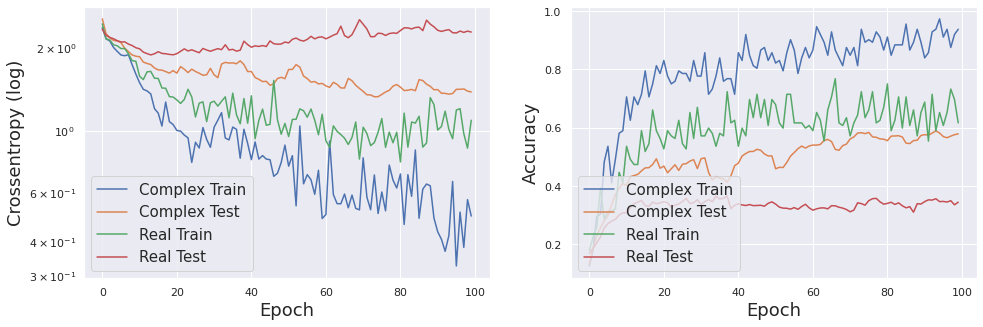

In [66]:
fig = compare_performances(HC_cmplx.training_history, HC_2ch.training_history)
#fig.savefig('phasemnist_200.pdf')

In [ ]:
# only example at 200
# signal of non-convergence / overfitting only in real model
# simlar behavior for ntrain < 1000 but no apparent relation among ntrain and convergence

### Different Weights Initialization

As Glorot et. al. proved in their famous work, a nice initialization for the parameters of a neural network can drastically improve the performances and make the training faster. So, we are going to test a few complex-valued initializers to verify if the same conclusions hold in the real world.

In [28]:
from complex_nn.initializers import CmplxRndUniform, CmplxTruncatedNormal, Cmplx_Xavier_Init, Cmplx_He_Init

In [29]:
# Let's start further reducing the dataset
train_dl, test_dl = build_dataloaders(mnist_path, data_transform, drop_length=65000, test_frac=0.5, batch_size=64)

In [30]:
weights_initializers_layer_1 = [CmplxRndUniform(-1., 1,), CmplxTruncatedNormal(), CmplxTruncatedNormal(0., 1./np.sqrt(28*28)), Cmplx_Xavier_Init(28*28, 32), Cmplx_He_Init(28*28)]
weights_initializers_layer_2 = [CmplxRndUniform(-1., 1,), CmplxTruncatedNormal(), CmplxTruncatedNormal(0., 1./np.sqrt(32)), Cmplx_Xavier_Init(32, 16), Cmplx_He_Init(32)]
weights_initializers_layer_3 = [CmplxRndUniform(-1., 1,), CmplxTruncatedNormal(), CmplxTruncatedNormal(0., 1./np.sqrt(16)), Cmplx_Xavier_Init(16, 10), Cmplx_He_Init(16)]

labels = ['Baseline Uniform(-1,1)', 'Baseline Truncated_normal(0, 1, -2, 2)', 'Complex Glorot Variant', 'Complex Xavier', 'Complex He']
scores_init = {k: None for k in labels}

for i in range(len(labels)):
    
    continue
    
    class ComplexMLP_Winit(hk.Module):
    
        def __init__(self):
            super().__init__()
            self.fc1 = Cmplx_Linear(32, w_init=weights_initializers_layer_1[i])
            self.fc2 = Cmplx_Linear(16, w_init=weights_initializers_layer_2[i])
            self.fc3 = Cmplx_Linear(10, w_init=weights_initializers_layer_3[i])
        
            self.batchnorm = CmplxBatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='channels_first')
            self.dropout = Dropout(0.3)
            self.flatten = hk.Flatten()        
            self.act = cardioid
        
        def __call__(self, z, is_training):
            z = self.flatten(z)
            z = self.act(self.fc1(z))
            z = self.batchnorm(z, is_training)
            z = self.dropout(z)
            z = self.act(self.fc2(z))
            z = self.fc3(z)
            return z
        
        
    HC_cmplx = Haiku_Classifier()
    _ = HC_cmplx.train(n_epochs = 50,
                       model = ComplexMLP_Winit, 
                       optimizer = cmplx_adam(step_size=1e-3),  
                       train_dataloader = train_dl,
                       test_dataloader = test_dl,
                       verbose = False
                       )    
        
    scores_init[labels[i]] = HC_cmplx.training_history
    
#with open('notebook_results/scores_init.pkl', 'wb') as f:
#    pickle.dump(scores_init, f)

In [33]:
with open('notebook_results/scores_init.pkl', 'rb') as f:
    scores_init = pickle.load(f)

Text(0.5, 1.0, 'Validation accuracy')

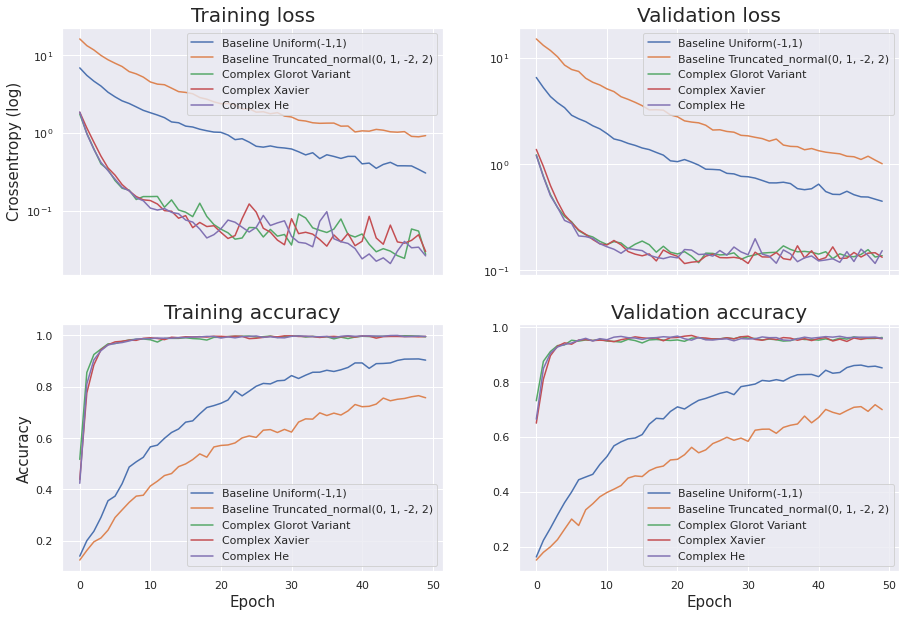

In [40]:
fig, ax = plt.subplots(2, 2, figsize=(15,10), sharex=True)
ax = ax.flatten()

for label in scores_init:
    
    history = scores_init[label]
    
    sns.lineplot(x=np.arange(len(history['train_loss'])), y=history['train_loss'], label=label, ax=ax[0])
    sns.lineplot(x=np.arange(len(history['val_loss'])), y=history['val_loss'], label=label, ax=ax[1])
    
    sns.lineplot(x=np.arange(len(history['train_acc'])), y=history['train_acc'], label=label, ax=ax[2])
    sns.lineplot(x=np.arange(len(history['val_acc'])), y=history['val_acc'], label=label, ax=ax[3])

    
ax[0].set_yscale('log')
ax[0].set_ylabel('Crossentropy (log)', fontsize=15)
ax[0].set_title('Training loss', fontsize=20)

ax[1].set_yscale('log')
#ax[1].set_ylabel('Crossentropy (log)', fontsize=15)
ax[1].set_title('Validation loss', fontsize=20)

ax[2].set_xlabel('Epoch', fontsize=15)
ax[2].set_ylabel('Accuracy', fontsize=15)
ax[2].set_title('Training accuracy', fontsize=20)

ax[3].set_xlabel('Epoch', fontsize=15)
#ax[3].set_ylabel('Accuracy', fontsize=15)
ax[3].set_title('Validation accuracy', fontsize=20)

In [42]:
#fig.savefig('performance_winit.pdf')

As we can see, the baseline random implementations do not work very well and lead to a quite slow training, while the proposal of Glorot and He, together with their complex-valued variants following the Rayleigh distribution, instead, guarantee very nice (and fast) convergence properties (at least in this particular case).